In [1]:
import torch
import numpy as np
import pickle
import json
from collections import defaultdict
import argparse
import os
from tqdm import tqdm

from src.prc import Encode, Decode, KeyGen

from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig, set_seed
from datasets import load_dataset

In [2]:
def build_huffman_tree(frequencies):
    #using a dictionary instead of a heap
    nodes = {symbol: {"freq": freq, "left": None, "right": None, "symbol": symbol} for symbol, freq in frequencies.items()}
    while len(nodes) > 1:
        #find two least frequent nodes
        left_symbol, right_symbol = sorted(nodes, key=lambda symbol: nodes[symbol]["freq"])[:2]
        left_node = nodes.pop(left_symbol)
        right_node = nodes.pop(right_symbol)
        new_node = {"freq": left_node["freq"] + right_node["freq"], "left": left_node, "right": right_node}
        nodes[f"{left_symbol}, {right_symbol}"] = new_node

    [(root_symbol, root_node)] = nodes.items()
    return root_node

def generate_huffman_codes(tree):
    codes = {}
    def traverse(node, current_code=""):
        if node["left"] is None and node["right"] is None:
            # Store the code for the symbol, not the frequency
            codes[node["symbol"]] = current_code
            return
        traverse(node["left"], current_code + "0")
        traverse(node["right"], current_code + "1")
    traverse(tree)
    return codes

def huffman_encode(frequencies):
  tree = build_huffman_tree(frequencies)
  codes = generate_huffman_codes(tree)
  encoding = {token: codes[token] for token, freq in frequencies.items()}
  return encoding

def huffman_decode(encoding, encoded_string):
    decoding = {code: symbol for symbol, code in encoding.items()} # This line was correct
    decoded_sequence = []
    current_code = ""
    for bit in encoded_string:
        current_code += bit
        if current_code in decoding:
            decoded_sequence.append(decoding[current_code])
            current_code = ""
    return decoded_sequence

In [17]:
class BinarizedModel:
    def __init__(self, original_model, encoding_key, decoding_key, n, tokenizer=None, frequencies=None, encoding=None, decoding=None):
        """
        Args:
            original_model: The original (non-binary) language model.
            encoding_key: The key for the PRC encoding.
            tokenizer: The tokenizer for the model.
            frequencies: A dictionary mapping original tokens to frequencies.
            encoding:  A dictionary mapping original tokens to binary strings (prefix-free).
            decoding: A dictionary mapping binary strings to original tokens.
        """
        self.original_model = original_model
        self.tokenizer = tokenizer
        self.device = next(original_model.parameters()).device
        self.encoding_key = encoding_key
        self.decoding_key = decoding_key
        self.prc_codeword = (Encode(encoding_key) + 1) / 2 # convert to {0, 1}

        assert len(self.prc_codeword) == n
        self.n = n

        self.prc_index = 0

        assert frequencies is not None or (encoding is not None and decoding is not None)

        if frequencies is not None:
            self.generate_huffman_encoding(frequencies)
        else:
            self.encoding = encoding
            self.decoding = decoding  # Corrected: This should be the *decoding* dict
            
        # Precompute prefix mappings for optimization
        self._precompute_prefix_mappings()

    def _precompute_prefix_mappings(self):
        """
        Precompute mappings from prefixes to possible tokens for faster lookup.
        This builds a dictionary mapping each possible prefix to the set of tokens
        that could follow it.
        """
        # Initialize prefix-to-tokens mapping
        self.prefix_to_tokens = {}
        
        # For each token and its binary code
        for token_id, code in self.encoding.items():
            # Add all prefixes of this code to the mapping
            for i in range(len(code) + 1):
                prefix = code[:i]
                if prefix not in self.prefix_to_tokens:
                    self.prefix_to_tokens[prefix] = set()
                self.prefix_to_tokens[prefix].add(token_id)
                
        # Convert sets to frozen sets for efficiency
        self.prefix_to_tokens = {prefix: frozenset(tokens) for prefix, tokens in self.prefix_to_tokens.items()}
        
        # Create mapping from prefix + bit to new possible tokens
        self.prefix_extension = {}
        for prefix in self.prefix_to_tokens:
            self.prefix_extension[(prefix, '0')] = frozenset(
                token_id for token_id in self.prefix_to_tokens[prefix]
                if len(self.encoding[token_id]) > len(prefix) and self.encoding[token_id][len(prefix):len(prefix)+1] == '0'
            )
            self.prefix_extension[(prefix, '1')] = frozenset(
                token_id for token_id in self.prefix_to_tokens[prefix]
                if len(self.encoding[token_id]) > len(prefix) and self.encoding[token_id][len(prefix):len(prefix)+1] == '1'
            )

    def generate_huffman_encoding(self, frequencies):
        self.encoding = huffman_encode(frequencies)
        self.decoding = {code: token_id for token_id, code in self.encoding.items()}
        
    def predict_binary_probs(self, original_token_probs, prefix):
        """
        Optimized version that calculates the probability of the next bit being 0 or 1.
        
        For bit 0: sum probabilities of tokens whose encoding starts with prefix+'0'
        For bit 1: sum probabilities of tokens whose encoding starts with prefix+'1'
        """
        # Get tokens that could follow this prefix with a 0 or 1
        prefix_plus_zero = (prefix, '0')
        prefix_plus_one = (prefix, '1')
        
        # Get tokens that could follow this prefix with a 0
        tokens_with_zero = self.prefix_extension.get(prefix_plus_zero, frozenset())
        # Get tokens that could follow this prefix with a 1
        tokens_with_one = self.prefix_extension.get(prefix_plus_one, frozenset())
        
        # If no possible continuations, return equal probabilities
        if not tokens_with_zero and not tokens_with_one:
            assert False
        
        # Calculate probability for bit '0'
        prob_of_zero = sum(original_token_probs.get(token_id, 0) for token_id in tokens_with_zero)
        # Calculate probability for bit '1'
        prob_of_one = sum(original_token_probs.get(token_id, 0) for token_id in tokens_with_one)
        
        # Normalize to ensure they sum to 1
        total = prob_of_zero + prob_of_one
        if total > 0:
            prob_of_zero /= total
            prob_of_one /= total
        else:
            # If all tokens have zero probability, default to equal probabilities
            prob_of_zero = 0.5
            prob_of_one = 0.5
        
        prob_of_one = min(prob_of_one, 1.0)
        # For efficiency, return both probabilities
        return 1.0 - prob_of_one, prob_of_one

    def sample_binary_token(self, x_i, hat_p_i):
        """
        Samples a binary token from the biased probabilities.

        x_i is the current index in the PRC codeword.
        hat_p_i is the E[p] which specifies the distribution over the next binary token.
        """
        if hat_p_i <= 0.5:
            # t_i <- Ber(2x_i * hat_p_i)
            return np.random.binomial(1, 2 * x_i * hat_p_i)
        else:
            # t_i <- Ber(1 - 2(1 - x_i)(1 - hat_p_i))
            return np.random.binomial(1, 1 - 2 * (1 - x_i) * (1 - hat_p_i))

    def watermarked_generate(self, prompt, num_bits):
        """
        Generates text using the watermarked, binarized model.
        Important: num_tokens is now the number of tokens in the *original* vocab.
        Args:
            num_tokens: the number of tokens *from the original vocabulary* we want to generate.
        """
        binary_tokens = []
        output_tokens = []
        output_text = ""

        input_ids = self.tokenizer.encode(prompt, return_tensors="pt").to(self.device) # Encode the prompt!


        with tqdm(total=num_bits, desc="Generating bits") as pbar:
            while len(binary_tokens) < num_bits:
                with torch.no_grad():
                    outputs = self.original_model(input_ids=input_ids)
                    logits = outputs.logits[0, -1, :]  # Get logits for the last token
                    probs = torch.softmax(logits, dim=0)
                    original_token_probs = {i: probs[i].item() for i in range(len(probs))}

                prefix = ""
                # loop until s becomes a valid encoding, and do not stop if eos_token is generated
                while True:
                    prob_of_zero, prob_of_one = self.predict_binary_probs(original_token_probs, prefix)
                    
                    # Sample bit using PRC watermarking
                    x_i = self.prc_codeword[self.prc_index].item() 
                    next_bit = self.sample_binary_token(x_i, prob_of_one)
                    binary_tokens.append(next_bit)
                    self.prc_index += 1
                    pbar.update(1)

                    # if we've used all the bits in the PRC codeword, reset it
                    if self.prc_index == len(self.prc_codeword):
                        self.prc_index = 0
                        self.prc_codeword = (Encode(self.encoding_key) + 1) / 2

                    prefix += str(next_bit)

                    if prefix in self.decoding:
                        decoded_token_id = self.decoding[prefix] 
                        output_tokens.append(decoded_token_id)
                        decoded_str = self.tokenizer.decode([decoded_token_id])
                        input_ids = torch.cat([input_ids, torch.tensor([[decoded_token_id]]).to(self.device)], dim=-1)
                        output_text += decoded_str
                        break # Exit the inner loop

                    if len(binary_tokens) >= num_bits:
                        break
                
                if len(binary_tokens) >= num_bits:
                    break

        return output_tokens, output_text
    
    def detect_windows(self, watermarked_text):
        """
        Detects if the provided text is watermarked, using PRC detection.
        """
        # convert watermarked_text to binary string using encoding
        watermarked_text_binary = ''.join([self.encoding[token_id] for token_id in watermarked_text])
        watermarked_text_binary = torch.tensor([int(bit) for bit in watermarked_text_binary], dtype=float)
        watermarked_text_binary = 2 * watermarked_text_binary - 1

        # instead of checking all substrings, let's just check windows of size n
        for i in range(0, len(watermarked_text_binary) - self.n + 1):
            window = watermarked_text_binary[i:i+self.n]
            if Decode(self.decoding_key, window) is not None:
                return True
        return False

    def detect_hamming(self, watermarked_text):
        """
        Detects if the provided text is watermarked, using hamming distance.
        """
        # convert watermarked_text to binary string using encoding
        watermarked_text_binary = ''.join([self.encoding[token_id] for token_id in watermarked_text])
        watermarked_text_binary = torch.tensor([int(bit) for bit in watermarked_text_binary], dtype=float)
        watermarked_text_binary = 2 * watermarked_text_binary - 1

        # wt(Px) < (1/2 - r^(-1/4)) * r, output 1, where P is the parity check matrix
        parity_check_matrix = self.decoding_key[1]
        # compute Px
        Px = parity_check_matrix @ watermarked_text_binary
        # count the number of 1s in Px
        num_1s = Px.sum().item()
        # compute the hamming distance
        hamming_distance = torch.sum(torch.abs(Px))
        return hamming_distance

In [18]:
def setup(vocab_size, exp_id, n, fpr, prc_t):
    if not os.path.exists(f'keys/{exp_id}.pkl'):  # Generate watermark key for the first time and save it to a file
        print("Generating PRC keys...")
        (encoding_key_ori, decoding_key_ori) = KeyGen(n, false_positive_rate=fpr, t=prc_t)  # Sample PRC keys
        with open(f'keys/{exp_id}.pkl', 'wb') as f:  # Save the keys to a file
            pickle.dump((encoding_key_ori, decoding_key_ori), f)
        with open(f'keys/{exp_id}.pkl', 'rb') as f:  # Load the keys from a file
            encoding_key, decoding_key = pickle.load(f)
        assert encoding_key[0].all() == encoding_key_ori[0].all()
    else:  # Or we can just load the keys from a file
        print(f'Loading PRC keys from file keys/{exp_id}.pkl')
        with open(f'keys/{exp_id}.pkl', 'rb') as f:
            encoding_key, decoding_key = pickle.load(f)
        print(f'Loaded PRC keys from file keys/{exp_id}.pkl')
    return encoding_key, decoding_key

In [19]:
parser = argparse.ArgumentParser('Args')
parser.add_argument('--prompt', type=str, default='Tell me a fantastical story about a wizard.')
parser.add_argument('--test_num', type=int, default=10)
parser.add_argument('--model_id', type=str, default='meta-llama/Llama-3.2-1B-Instruct')
# parser.add_argument('--dataset_id', type=str, default='databricks/databricks-dolly-15k')
parser.add_argument('--inf_steps', type=int, default=50)
parser.add_argument('--nowm', type=int, default=0)
parser.add_argument('--fpr', type=float, default=0.00001)
parser.add_argument('--prc_t', type=int, default=3)
args = parser.parse_args([])
print(args)

Namespace(prompt='Tell me a fantastical story about a wizard.', test_num=10, model_id='meta-llama/Llama-3.2-1B-Instruct', inf_steps=50, nowm=0, fpr=1e-05, prc_t=3)


In [20]:
hf_cache_dir = '/home/lawrence/.cache/huggingface/hub'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n = 2**11 # the length of a PRC codeword (for stable diffusion)
test_num = args.test_num
model_id = args.model_id
nowm = args.nowm
fpr = args.fpr
prc_t = args.prc_t
exp_id = f'binarize_num_{test_num}_steps_{args.inf_steps}_fpr_{fpr}_nowm_{nowm}_n_{n}'


In [21]:
print("Loading model...")
config = AutoConfig.from_pretrained(model_id)
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.padding_side = 'left'

    # Add padding token if it doesn't exist
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

vocab_size = config.vocab_size
eos_token_id = tokenizer.eos_token_id

model = AutoModelForCausalLM.from_pretrained(model_id)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

print(f"Model loaded on {device}")

Loading model...
Model loaded on cuda


In [22]:
# Get the prompt
prompt = args.prompt
print(f"Prompt: {prompt}")

# Get the encoding key
print(f"Setting up PRC keys for {exp_id}")
encoding_key, decoding_key = setup(vocab_size, exp_id, n, fpr, prc_t)
print(f"PRC keys set up")

if not os.path.exists(f'encoding_{exp_id}.pkl'):
    token_counts = {token_id: 0 for token_id in range(vocab_size)}
    with open("pride_and_prejudice.txt", "r", encoding="utf-8") as f:
        example_corpus = f.readlines()
    for sentence in example_corpus:
        input_ids = tokenizer.encode(sentence)
        for token_id in input_ids:
            token_counts[token_id] += 1

    encoding = huffman_encode(token_counts)
    # save encoding to file
    with open(f'encoding_{exp_id}.pkl', 'wb') as f:
        pickle.dump(encoding, f)
else:
    with open(f'encoding_{exp_id}.pkl', 'rb') as f:
        encoding = pickle.load(f)
print(f"Encoding loaded")

decoding = {code: token_id for token_id, code in encoding.items()}

# Binarize the model
binarized_model = BinarizedModel(
    original_model=model,
    encoding_key=encoding_key,
    decoding_key=decoding_key,
    n=n,
    tokenizer=tokenizer,
    encoding=encoding,
    decoding=decoding)
print(f"Binarized model loaded")

Prompt: Tell me a fantastical story about a wizard.
Setting up PRC keys for binarize_num_10_steps_50_fpr_1e-05_nowm_0_n_2048
Loading PRC keys from file keys/binarize_num_10_steps_50_fpr_1e-05_nowm_0_n_2048.pkl
Loaded PRC keys from file keys/binarize_num_10_steps_50_fpr_1e-05_nowm_0_n_2048.pkl
PRC keys set up
Encoding loaded
Binarized model loaded


In [23]:
# Generate text
output_tokens, output_text = binarized_model.watermarked_generate(prompt, num_bits=n)
print(f"Output text: {output_text}")

Generating bits:   0%|                               | 0/2048 [00:00<?, ?it/s]

Generating bits: 100%|████████████████████| 2048/2048 [04:46<00:00,  7.14it/s]

Output text:  Zephyr, the Guardian of the Forest
In the heart of a mystical realm, hidden from mortal eyes, stood the ancient forest of Elvendom. Its canopy of iridescent leaves and branches seemed to defy gravity as the wind whispered secrets to the trees. It was a place where magic soaked in like a fine wine, where the pulse of nature sustained civilizations and pulsed with an otherworldly energy.
Here was where Zephyr, the Guardian of the Forest, resided. Zephyr's tale began over 800 years ago, when the world was young and still shrouded in darkness. With wild hair as golden as


In [122]:
def detect_hamming_binary(binarized_model, watermarked_text_binary):
    """
    Detects if the provided binary string is watermarked, using hamming distance.
    """
    if len(watermarked_text_binary) < binarized_model.n:
        print(f"appending {binarized_model.n - len(watermarked_text_binary)} zeros")
        watermarked_text_binary = torch.cat([watermarked_text_binary, torch.zeros(binarized_model.n - len(watermarked_text_binary))])

    # wt(Px) < (1/2 - r^(-1/4)) * r, output 1, where P is the parity check matrix
    parity_check_matrix = binarized_model.decoding_key[1]
    r = parity_check_matrix.shape[0]
    
    # compute Px
    Px = parity_check_matrix @ watermarked_text_binary
    
    # Calculate the hamming weight for values in {-1, 1}
    # First convert from {-1, 1} to {0, 1} representation
    Px_binary = (Px + 1) / 2
    hamming_weight = np.sum(Px_binary)
    
    threshold = (1/2 - r**(-1/4)) * r
    # if below threshold, then detection
    result = hamming_weight < threshold
    
    return threshold, hamming_weight, result

def detect_hamming_text(binarized_model, watermarked_text):
    """
    Detects if the provided text is watermarked, using hamming distance.
    """
    # convert watermarked_text to binary string using encoding
    watermarked_text_binary = ''.join([binarized_model.encoding[token_id] for token_id in watermarked_text])
    watermarked_text_binary = torch.tensor([int(bit) for bit in watermarked_text_binary], dtype=float)
    watermarked_text_binary = 2 * watermarked_text_binary - 1

    return detect_hamming_binary(binarized_model, watermarked_text_binary)

In [123]:
threshold, hamming_weight, result = detect_hamming_text(binarized_model, output_tokens)
print(threshold)
print(hamming_weight)
print(result)

appending 4 zeros
493.42963641011494
738.0
False


In [49]:
def convert_watermarked_text_to_binary(binarized_model, watermarked_text):
    watermarked_text_binary = ''.join([binarized_model.encoding[token_id] for token_id in watermarked_text])
    watermarked_text_binary = torch.tensor([int(bit) for bit in watermarked_text_binary], dtype=float)
    watermarked_text_binary = 2 * watermarked_text_binary - 1
    return watermarked_text_binary

def corrupt_watermarked_text(binarized_model, watermarked_text, corruption_rate=0.1):
    """
    Randomly flips bits in the binary representation of watermarked text.
    
    Args:
        binarized_model: The binarized model containing encoding information.
        watermarked_text: List of token IDs to be corrupted.
        corruption_rate: Probability of flipping each bit (between 0 and 1).
        
    Returns:
        Corrupted binary tensor with values in {-1, 1}.
    """
    # Convert the watermarked text to binary format
    watermarked_text_binary = convert_watermarked_text_to_binary(binarized_model, watermarked_text)
    
    # Create a mask of bits to flip based on the corruption rate
    num_bits = len(watermarked_text_binary)
    flip_mask = torch.rand(num_bits) < corruption_rate
    
    # Flip the selected bits (multiply by -1 since values are {-1, 1})
    watermarked_text_binary[flip_mask] *= -1
    
    return watermarked_text_binary
    

In [67]:
watermarked_text_binary = convert_watermarked_text_to_binary(binarized_model, output_tokens)
corrupted_watermarked_text_binary = corrupt_watermarked_text(binarized_model, output_tokens)
print(f"corruptions: {torch.sum(torch.abs(watermarked_text_binary - corrupted_watermarked_text_binary))}")
print(f"length: {len(watermarked_text_binary)}")

corruptions: 422.0
length: 2044


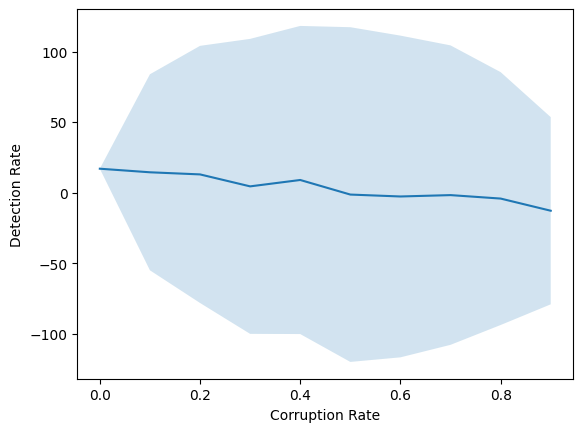

In [85]:
import matplotlib.pyplot as plt
# compute average detection rate
corruption_rates = np.arange(0, 1, 0.1)
detection_rates = []
detection_rates_std = []
for corruption_rate in corruption_rates:
    detection_rate = []
    for i in range(1000):
        corrupted_watermarked_text_binary = corrupt_watermarked_text(binarized_model, output_tokens, corruption_rate)
        threshold,= detect_hamming_binary(binarized_model, corrupted_watermarked_text_binary)
        detection_rate.append(detection_result)
    detection_rates.append(np.mean(detection_rate))
    detection_rates_std.append(np.std(detection_rate))
plt.plot(corruption_rates, detection_rates)
plt.fill_between(corruption_rates, np.array(detection_rates) - np.array(detection_rates_std), np.array(detection_rates) + np.array(detection_rates_std), alpha=0.2)
plt.xlabel("Corruption Rate")
plt.ylabel("Detection Rate")
plt.show()

In [124]:
# generate random binary string
random_binary_string = torch.rand(n)
random_binary_string[random_binary_string < 0.5] = -1
random_binary_string[random_binary_string >= 0.5] = 1
threshold, hamming_weight, result = detect_hamming_binary(binarized_model, random_binary_string)
print(f"threshold: {threshold}")
print(f"hamming_weight: {hamming_weight}")
print(f"result: {result}")


threshold: 493.42963641011494
hamming_weight: 773.0
result: False
